Базирано на [примерите в документацията](https://www.tensorflow.org/tutorials/text/text_generation) на Tensorflow.

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
with open('page_revisions_text', 'rb') as text_file:
    data = text_file.read()

In [3]:
articles = data.split(b'\0')

In [4]:
len(articles)

243427

In [6]:
sum(len(a) for a in articles[:300])

2075336

In [37]:
first_articles = '. '.join(a.decode('utf-8') for a in articles[:300])
del data

In [38]:
# The unique characters in the file
vocab = sorted(set(first_articles))
print ('{} unique characters'.format(len(vocab)))

1113 unique characters


In [39]:
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in first_articles])

In [40]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '#' :   5,
  '$' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  ...
}


In [41]:
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [46]:
seq_length = 100
examples_per_epoch = len(first_articles) // (seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

#
R
E
D
I


In [47]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'#REDIRECT [[AAA]]. #REDIRECT [[Algeria]]{{R from CamelCase}}. #REDIRECT [[American Samoa]]{{R from Ca'
'melCase}}. #REDIRECT [[Applied ethics]]\n. #REDIRECT [[Accessible_computing]]. #REDIRECT [[Ada program'
"ming language]]. {{Anarchism}}\n'''Anarchism''' originated as a term of abuse first used against early"
' [[working class]] [[radical]]s including the [[Diggers]] of the [[English Revolution]] and the [[san'
"s-culotte|''sans-culottes'']] of the [[French Revolution]].[http://uk.encarta.msn.com/encyclopedia_76"


In [48]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [49]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '#REDIRECT [[AAA]]. #REDIRECT [[Algeria]]{{R from CamelCase}}. #REDIRECT [[American Samoa]]{{R from C'
Target data: 'REDIRECT [[AAA]]. #REDIRECT [[Algeria]]{{R from CamelCase}}. #REDIRECT [[American Samoa]]{{R from Ca'


In [50]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 5 ('#')
  expected output: 52 ('R')
Step    1
  input: 52 ('R')
  expected output: 39 ('E')
Step    2
  input: 39 ('E')
  expected output: 38 ('D')
Step    3
  input: 38 ('D')
  expected output: 43 ('I')
Step    4
  input: 43 ('I')
  expected output: 52 ('R')


In [51]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [54]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [55]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [56]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [57]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 1113) # (batch_size, sequence_length, vocab_size)


In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           284928    
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 1113)          1140825   
Total params: 5,364,057
Trainable params: 5,364,057
Non-trainable params: 0
_________________________________________________________________


In [59]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [60]:
sampled_indices

array([ 692, 1082,   49,  930, 1081,  758,  800,  230,  154,  711,  631,
        227,  633,  769,  223, 1050,  620,  721,   34,  722,  363,  217,
        508,  494,  940,  124,  116,  627,  351,  426,  591,  170,  284,
         24,  272,  657,  739,  810, 1057,  333,  474,  184,  385, 1058,
        193,  792,  558,  526,  219,  447,  460,  499,  864,  534,  598,
        401,  573,  511,  978,  221,   18,  268,  210,  573,  283,  836,
        469,  162,  510,  140,  895,  542,  256,  508,  860,   15,  605,
        806,  768,   60,   30,  377,  262,  766, 1110,  504,  945,  762,
        154,   56,  378,  409,  253,  387,  835,   50,  627,  751,  579,
        697], dtype=int64)

In [61]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'rein the industrialists of America go on strike and retreat to a mountainous hideaway. The American '

Next Char Predictions: 
 '−지O第증ム勸έûんᐅΠᐱ・Ά속ንカ@ガثˈெப者×ÅᎸתेაěи6Тậテ号알זફőى앙ų准ยಸ́বূல戈സთआุொ錬̅0Мɹุз媽કčைë業จόெ府-რ原ンZ<فДレ호ா臥ョûVقटχً女PᎸフไあ'


In [62]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 1113)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       7.0163283


In [63]:
model.compile(optimizer='adam', loss=loss)

In [64]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [65]:
EPOCHS=10

In [66]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 319 steps
Epoch 1/10
319/319 [==============================] - 5735s 18s/step - loss: 2.6419
Epoch 2/10
319/319 [==============================] - 5122s 16s/step - loss: 1.8965
Epoch 3/10
319/319 [==============================] - 5116s 16s/step - loss: 1.6315
Epoch 4/10
319/319 [==============================] - 5116s 16s/step - loss: 1.5061
Epoch 5/10
319/319 [==============================] - 5099s 16s/step - loss: 1.4266
Epoch 6/10
319/319 [==============================] - 5149s 16s/step - loss: 1.3684
Epoch 7/10
319/319 [==============================] - 5097s 16s/step - loss: 1.3209
Epoch 8/10
319/319 [==============================] - 5103s 16s/step - loss: 1.2803
Epoch 9/10
319/319 [==============================] - 5112s 16s/step - loss: 1.2444
Epoch 10/10
319/319 [==============================] - 5104s 16s/step - loss: 1.2136


In [68]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_10'

In [69]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            284928    
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 1113)           1140825   
Total params: 5,364,057
Trainable params: 5,364,057
Non-trainable params: 0
_________________________________________________________________


In [71]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [121]:
print(generate_text(model, start_string=u"Anarchy"))

Anarchy; this is runned to the human being in the human ure [[history conceutoda]]s canned off the name of [[philosopher|EVP]] continued to spell research with [[wild programmings with autism ambiguity that homestical crisis]] tay planned to become [[Alaska Constitution is fuel (just and parks). Novelite also hope to upper and sometimes early commonly satellite [[general left anather winder than 'Hand's one eastern part of King, American Samol, and a he termed in a cure signson sates|USA]].

=== Errong to==
*''[[Agave decendency|topics''.

==Origins of the most Templeoses was described by [[Yull montaジ]]; [[Space Space Factbook]] and [[Lincoln Congo]] (GUC) on the court as a [[mythology|ethane]]. However, it doesings from the soon. When the Moon by the [[Pollierés dent, [[Athana]] in [[1004 service]] ordinations out of three gives in 40.5 increased vitami² of the SCS-context.

== Albania]
* [http://www.imdb.png Militana The Machina of Program Hilleresm Pagmetry with domestic anthropolo

In [127]:
def predict_chars(model, start_string):
  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Here batch size == 1
  model.reset_states()

  predictions = model(input_eval)
  predictions = tf.squeeze(predictions, 0)
    
  return predictions

logit_predictions = predict_chars(model, 'Albania')
prediction = tf.nn.softmax(logit_predictions[-1])

In [128]:
sum(prediction).numpy()

0.9999993

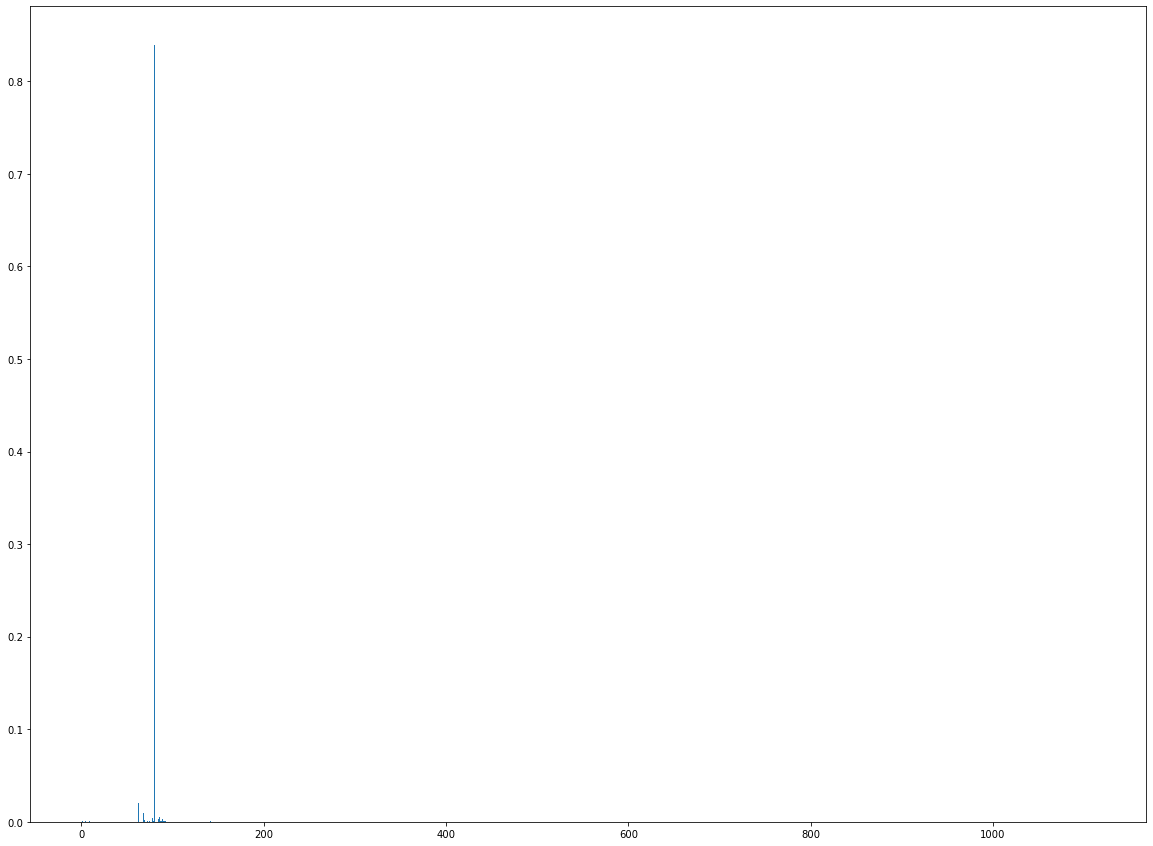

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.bar(range(len(prediction)), prediction);

In [130]:
[[idx2char[index], tensor.numpy()] for index, tensor in enumerate(prediction) if tensor.numpy() > .02]

[[' ', 0.037231553], [']', 0.020161152], ['n', 0.83898], ['|', 0.036699034]]

In [131]:
import huffman

In [132]:
huffman.codebook([idx2char[index], tensor.numpy()] for index, tensor in enumerate(prediction))

{'\t': '0111100101001111110',
 '\n': '011111010',
 ' ': '001',
 '!': '01110100111',
 '"': '0111010011011100',
 '#': '0111100001',
 '$': '01111111101110001100',
 '%': '010100111110110',
 '&': '0101001101011',
 "'": '01010010',
 '(': '01111001001101',
 ')': '011110010000',
 '*': '01111100101001000',
 '+': '0101001100001100',
 ',': '01111110',
 '-': '011110010101',
 '.': '011111110',
 '/': '0111111110011',
 '0': '0111110010010010001',
 '1': '0111110010101111111',
 '2': '010100111111101011',
 '3': '01111111101100000010',
 '4': '01110100110111101111001',
 '5': '01111001001110011101101',
 '6': '011111111011100000010',
 '7': '0101001100111010100',
 '8': '0101001100010101001100',
 '9': '01111001010000001101010',
 ':': '011111001011001',
 ';': '01010011011100',
 '<': '0111000110000',
 '=': '0111100101101',
 '>': '0111110010110111',
 '?': '011110010100111110',
 '@': '01010011111011101010',
 'A': '0111010010110',
 'B': '0101001111100101001',
 'C': '01111001010000101',
 'D': '01010011110000',
 'E'

In [150]:
article = articles[120].decode('utf-8')
len(article)

25524

In [192]:
def huffman_archive(model, text):
    archived = ''
    input_eval = [char2idx[s] for s in ' ']
    input_eval = tf.expand_dims(input_eval, 0)
  
    # Empty string to store our results
    text_generated = []

    model.reset_states()

    for character in text:
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
  
        probabilities = tf.nn.softmax(predictions[0])
        codebook = huffman.codebook([index, tensor.numpy()] for index, tensor in enumerate(probabilities))

        code = codebook[char2idx[character]]
        print(code, end='')
        archived += code

        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([char2idx[character]], 0)
  
    return archived

archived = huffman_archive(model, article[:2500])
print('\nTotal length:', len(archived))

1000101010000110111001111111111011010101011111111100101100111101110111111100011001100011111010011111110011110011011011110011111011111011011111001001111101111010000110001111111100101111111111101111000111110010011111101010110011011111111110111111111111000111010100101010011111100111011111110010011111101111101111111100101110001111001001010001111010101110110101111101000000111111111110111110111100011111100101101111101111110101010111111100111011000011000111010110011111110011111101111101101010001001110111011101111110011110001110010111110111011111111100001011011111110000011111111100001111111111111100001011001111111100111110111111011100110111011110101011110100110111111101110111111001101010111110110101111111101000111110111111111101110101100011111011101000101110011111110110101111011111111111101111100011011110110110100110001011111111111111100010101001110110110110100011101110011011010001100011111010111011010111111100010011111100101011100111011111111101111101111111111110101011101110000000011111110111

Прави впечатление, че доста по-често имаме "1" в изхода. Използвайки [аритметично кодиране](https://en.wikipedia.org/wiki/Arithmetic_coding) бихме могли да смъкнем още малко от размера...

In [193]:
len(list(filter(lambda x: x == '1', archived)))

3196

In [207]:
k = (3196 / 4823)
-k * np.log2(k) - (1-k) * np.log2(1-k)

0.9222523478954188

С подобна имплементация, с текущата невронна мрежа, с кодиране на Huffman и аритметична компресия можем да предположим за размер на файла в мегабайти:

In [208]:
0.922 * 4823 / (2500 * 8) * 888

197.4381864

In [198]:
def huffman_archive_size(model, text):
    archived_size = 0
    input_eval = [char2idx[s] for s in ' ']
    input_eval = tf.expand_dims(input_eval, 0)
  
    # Empty string to store our results
    text_generated = []

    model.reset_states()

    for character in text:
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
  
        probabilities = tf.nn.softmax(predictions[0])
        codebook = huffman.codebook([index, tensor.numpy()] for index, tensor in enumerate(probabilities))

        code = codebook[char2idx[character]]
        archived_size += len(code)

        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([char2idx[character]], 0)
  
    return archived_size

archived_size = huffman_archive_size(model, article)
print('\nTotal length:', archived_size)


Total length: 50773


Нека видим каква компресия сме постигнали по-дълъг текст:

In [202]:
archived_size / (len(article) * 8)

0.2486532283341169